<a href="https://colab.research.google.com/github/vressegu/sdeflow-light/blob/main/sdeflow_equivalent_sdes_MSGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn

## 1. Initialize dataset

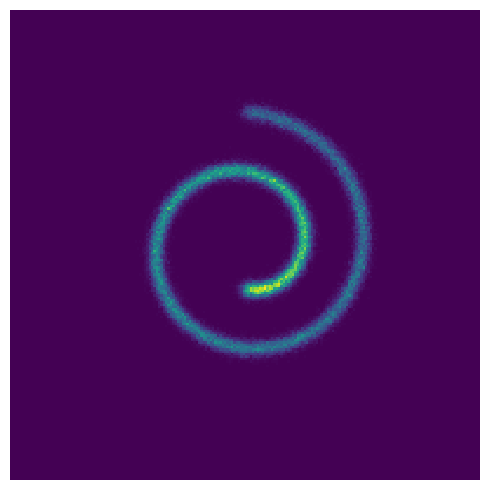

In [2]:
from sklearn.datasets import make_swiss_roll
class SwissRoll:
    """
    Swiss roll distribution sampler.
    noise control the amount of noise injected to make a thicker swiss roll
    """
    def sample(self, n, noise=0.5):
        if noise is None:
            noise = 0.5
        return torch.from_numpy(
            make_swiss_roll(n, noise=noise)[0][:, [0, 2]].astype('float32') / 5.) # Changed: Pass noise as a keyword argument

import matplotlib.pyplot as plt
sampler = SwissRoll()
x = sampler.sample(100000).data.numpy()
plt.close('all')
fig = plt.figure(figsize=(5, 5))
_ = plt.hist2d(x[:,0], x[:,1], 200, range=((-5,5), (-5,5)))
plt.axis('off')
plt.tight_layout()

## 2. Define models

### 4.2. Define Euler Maruyama method with a step size $\Delta t$

In [3]:
def euler_maruyama_sampler(sde, x_0, num_steps, lmbd=0., keep_all_samples=True):
    """
    Euler Maruyama method with a step size delta
    """
    # init
    device = sde.T.device
    batch_size = x_0.size(0)
    ndim = x_0.dim()-1
    T_ = sde.T.cpu().item()
    delta = T_ / num_steps
    ts = torch.linspace(0, 1, num_steps + 1) * T_

    # sample
    xs = []
    x_t = x_0.detach().clone().to(device)
    t = torch.zeros(batch_size, *([1]*ndim), device=device)
    with torch.no_grad():
        for i in range(num_steps):
            t.fill_(ts[i].item())
            mu = sde.mu(t, x_t, lmbd=lmbd)
            sigma = sde.sigma(t, x_t, lmbd=lmbd)
            x_t = x_t + delta * mu + delta ** 0.5 * sigma * torch.randn_like(x_t) # one step update of Euler Maruyama method with a step size delta
            if keep_all_samples or i == num_steps-1:
                xs.append(x_t.to('cpu'))
            else:
                pass
    return xs

### 2.1. Define SDEs

In [12]:
Log2PI = float(np.log(2 * np.pi))

def log_normal(x, mean, log_var, eps=0.00001):
    z = - 0.5 * Log2PI
    return - (x - mean) ** 2 / (2. * torch.exp(log_var) + eps) - log_var / 2. + z

def sample_rademacher(shape):
    return (torch.rand(*shape).ge(0.5)).float() * 2 - 1

def sample_gaussian(shape):
    return torch.randn(*shape)

def sample_v(shape, vtype='rademacher'):
    if vtype == 'rademacher':
        return sample_rademacher(shape)
    elif vtype == 'normal' or vtype == 'gaussian':
        return sample_gaussian(shape)
    else:
        Exception(f'vtype {vtype} not supported')

class VariancePreservingSDE(torch.nn.Module):
    """
    Implementation of the variance preserving SDE proposed by Song et al. 2021
    See eq (32-33) of https://openreview.net/pdf?id=PxTIG12RRHS
    """
    # This class need to be changed since the forward SDE cannot be solved analitically
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0, t_epsilon=0.001):
        super().__init__()
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T
        self.t_epsilon = t_epsilon

    @property
    def logvar_mean_T(self):
        logvar = torch.zeros(1)
        mean = torch.zeros(1)
        return logvar, mean

    def beta(self, t):
        return self.beta_min + (self.beta_max-self.beta_min)*t

    def mean_weight(self, t):
        return torch.exp(-0.25 * t**2 * (self.beta_max-self.beta_min) - 0.5 * t * self.beta_min)

    def var(self, t):
        return 1. - torch.exp(-0.5 * t**2 * (self.beta_max-self.beta_min) - t * self.beta_min)

    def f(self, t, y):
        return - 0.5 * self.beta(t) * y

    # TODO
    def div_Sigma(self, t, y):
        return torch.zeros_like(y)

    def g(self, t, y):
        beta_t = self.beta(t)
        return torch.ones_like(y) * beta_t**0.5

    def sample(self, t, y0, return_noise=False):
        """
        sample yt | y0
        if return_noise=True, also return std and g for reweighting the denoising score matching loss
        """
        mu = self.mean_weight(t) * y0
        std = self.var(t) ** 0.5
        epsilon = torch.randn_like(y0)
        yt = epsilon * std + mu
        if not return_noise:
            return yt
        else:
            return yt, epsilon, std, self.g(t, yt)

    def sample_debiasing_t(self, shape):
        """
        non-uniform sampling of t to debias the weight std^2/g^2
        the sampling distribution is proportional to g^2/std^2 for t >= t_epsilon
        for t < t_epsilon, it's truncated
        """
        raise NotImplementedError('See the official repository.')
        # return sample_vp_truncated_q(shape, self.beta_min, self.beta_max, t_epsilon=self.t_epsilon, T=self.T)

class PluginReverseSDE(torch.nn.Module):
    """
    inverting a given base sde with drift `f` and diffusion `g`, and an inference sde's drift `a` by
    f <- g a - f
    g <- g
    (time is inverted)
    """
    def __init__(self, base_sde, drift_a, T, vtype='rademacher', debias=False):
        super().__init__()
        self.base_sde = base_sde
        self.a = drift_a
        self.T = T
        self.vtype = vtype
        self.debias = debias

    # Drift
    def mu(self, t, y, lmbd=0.):
        # for us, lambda = 0
        return (1. - 0.5 * lmbd) * self.base_sde.g(self.T-t, y) * self.a(y, self.T - t.squeeze()) - \
               self.base_sde.f(self.T - t, y) \
               + self.div_Sigma(self.T - t, y)

    # div(Sigma)
    def div_Sigma(self, t, y, lmbd=0.):
        return (1. - lmbd) * self.base_sde.div_Sigma(self.T-t, y)

    # Diffusion
    def sigma(self, t, y, lmbd=0.):
        return (1. - lmbd) ** 0.5 * self.base_sde.g(self.T-t, y)

    # WARNING : DSM is not relevant in MSGM
    # SSM needs to be defined instead
    @torch.enable_grad()
    def dsm(self, x):
        """
        denoising score matching loss
        """
        if self.debias:
            t_ = self.base_sde.sample_debiasing_t([x.size(0), ] + [1 for _ in range(x.ndim - 1)])
        else:
            t_ = torch.rand([x.size(0), ] + [1 for _ in range(x.ndim - 1)]).to(x) * self.T
        y, target, std, g = self.base_sde.sample(t_, x, return_noise=True)
        a = self.a(y, t_.squeeze())

        return ((a * std / g + target) ** 2).view(x.size(0), -1).sum(1, keepdim=False) / 2
        # / g is not convenient for g being a dense matrix of rank d-1...

    @torch.enable_grad()
    def ssm(self, x):
        """
        estimating the SSM loss of the plug-in reverse SDE by sampling t uniformly between [0, T], and by estimating
        div(mu) using the Hutchinson trace estimator
        """
        # Is self.debias case needed as in DSM ???
        t_ = torch.rand([x.size(0), ] + [1 for _ in range(x.ndim - 1)]).to(x) * self.T
        qt = 1 / self.T
        y = self.base_sde.sample(t_, x).requires_grad_()

        a = self.a(y, t_.squeeze())

        # OU case
        # mu = self.base_sde.g(t_, y) * a - self.base_sde.f(t_, y)
        # mu_to_div = mu

        # General case
        mu = self.base_sde.g(t_, y) * a - self.base_sde.f(t_, y) + self.base_sde.div_Sigma(t_, y)
        mu_to_div = mu - 0.5 * self.base_sde.div_Sigma(t_, y)

        # Simpler and faster way for MSGM
        #mu_to_div = self.base_sde.g(t_, y) * a

        v = sample_v(x.shape, vtype=self.vtype).to(y)

        mMu = (
              torch.autograd.grad(mu_to_div, y, v, create_graph=self.training)[0] * v
        ).view(x.size(0), -1).sum(1, keepdim=False)

        mNu = (a ** 2).view(x.size(0), -1).sum(1, keepdim=False) / 2

        return mMu + mNu

    @torch.enable_grad()
    def elbo_random_t_slice(self, x):
        """
        estimating the ELBO of the plug-in reverse SDE by sampling t uniformly between [0, T], and by estimating
        div(mu) using the Hutchinson trace estimator
        """
        t_ = torch.rand([x.size(0), ] + [1 for _ in range(x.ndim - 1)]).to(x) * self.T
        qt = 1 / self.T
        y = self.base_sde.sample(t_, x).requires_grad_()

        # Following lines to adapt since the latent space is not Gaussian(easier sampler for final time ?)
        yT = self.base_sde.sample(torch.ones_like(t_) * self.base_sde.T, x)
        lp = log_normal(yT, torch.zeros_like(yT), torch.zeros_like(yT)).view(x.size(0), -1).sum(1)

        return lp - self.ssm(x) / qt

### 2.2. Define MLP

In [13]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sigmoid(x)*x

class MLP(nn.Module):
    def __init__(self,
                 input_dim=2,
                 index_dim=1,
                 hidden_dim=128,
                 act=Swish(),
                 ):
        super().__init__()
        self.input_dim = input_dim
        self.index_dim = index_dim
        self.hidden_dim = hidden_dim
        self.act = act

        self.main = nn.Sequential(
            nn.Linear(input_dim+index_dim, hidden_dim),
            act,
            nn.Linear(hidden_dim, hidden_dim),
            act,
            nn.Linear(hidden_dim, hidden_dim),
            act,
            nn.Linear(hidden_dim, input_dim),
            )

    def forward(self, input, t):
        # init
        sz = input.size()
        input = input.view(-1, self.input_dim)
        t = t.view(-1, self.index_dim).float()

        # forward
        h = torch.cat([input, t], dim=1) # concat
        output = self.main(h) # forward
        return output.view(*sz)

### 2.3. Define evaluate function (compute ELBO)


In [14]:
@torch.no_grad()
def evaluate(gen_sde, x_test):
    gen_sde.eval()
    num_samples = x_test.size(0)
    test_elbo = gen_sde.elbo_random_t_slice(x_test)
    gen_sde.train()
    return test_elbo.mean(), test_elbo.std() / num_samples ** 0.5

## 3. Train

In [ ]:
# init device
if torch.cuda.is_available():
    device = 'cuda'
    print('use gpu\n')
elif torch.backends.mps.is_available():
    device = 'mps'
    print('use mps\n')
else:
    device = 'cpu'
    print('use cpu\n')

# arguments
T0 = 1
vtype = 'rademacher'
lr = 0.001
batch_size = 256
iterations = 100000
print_every = 5000

# init models
drift_q = MLP(input_dim=2, index_dim=1, hidden_dim=128).to(device)
T = torch.nn.Parameter(torch.FloatTensor([T0]), requires_grad=False)
inf_sde = VariancePreservingSDE(beta_min=0.1, beta_max=20.0, T=T).to(device)
gen_sde = PluginReverseSDE(inf_sde, drift_q, T, vtype=vtype, debias=False).to(device)

# init optimizer
optim = torch.optim.Adam(gen_sde.parameters(), lr=lr)

# train
start_time = time.time()
for i in range(iterations):
    optim.zero_grad() # init optimizer
    x = sampler.sample(batch_size).to(device) # sample data
    loss = gen_sde.ssm(x).mean() # forward and compute loss
    #loss = gen_sde.ssm(x).mean() # forward and compute loss
    loss.backward() # backward
    optim.step() # update

    # print
    if (i+1) % print_every == 0:
        # elbo
        elbo, elbo_std = evaluate(gen_sde, x)

        # print
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} | elbo {:8.3f} | elbo std {:8.3f} '
              .format(i+1, elapsed*1000/print_every, loss.item(), elbo.item(), elbo_std.item()))
        start_time = time.time()

use gpu

| iter   5000 |  4.84 ms/step | loss   -0.655 | elbo   -3.964 | elbo std    0.724 
| iter  10000 |  4.82 ms/step | loss   -0.246 | elbo   -2.870 | elbo std    1.117 
| iter  15000 |  4.86 ms/step | loss   -0.806 | elbo   -2.344 | elbo std    0.831 
| iter  20000 |  4.83 ms/step | loss   -1.798 | elbo   -2.678 | elbo std    0.831 


## 4. Visualize

### 4.1. Define plotting tools

In [ ]:
def get_2d_histogram_plot(data, val=5, num=256, use_grid=False, origin='lower'):
    xmin = -val
    xmax = val
    ymin = -val
    ymax = val

    # get data
    x = data[:, 0]
    y = data[:, 1]

    # get histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, range=[[xmin, xmax], [ymin, ymax]], bins=num)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # plot heatmap
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(heatmap.T, extent=extent, cmap='jet', origin=origin)
    ax.grid(False)
    if use_grid:
        plt.xticks(np.arange(-val, val+1, step=1))
        plt.yticks(np.arange(-val, val+1, step=1))
    else:
        plt.xticks([])
        plt.yticks([])

    # tight
    plt.tight_layout()

    # draw to canvas
    fig.canvas.draw()  # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # close figure
    plt.close()
    return image

def plot_selected_inds(xs, inds, use_xticks=True, use_yticks=True):
    imgs_ = []
    for ind in inds:
        imgs_ += [get_2d_histogram_plot(xs[ind].numpy())]
    img_ = np.concatenate(imgs_, axis=1)

    height, width, _ = img_.shape
    height_per_img = width_per_img = height
    figwidth = 25
    fontsize = 15
    if use_xticks:
        xticks = [0.5*width_per_img + width_per_img*i for i in range(len(inds))]
        xticklabels = [r'$i={:d}$'.format(ind+1) for ind in inds]
    else:
        xticks, xticklabels = [], []
    if use_yticks:
        yticks = [0.5*height_per_img]
        yticklabels = [r'$\lambda={:.2g}$'.format(lmbd)]
    else:
        yticks, yticklabels = [], []

    fig = plt.figure(figsize=(figwidth, figwidth*height/width))
    ax = fig.add_subplot(111)
    ax.imshow(img_)
    axis_color = 'white' #'white'
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['top'].set_color(axis_color)
    ax.spines['left'].set_color(axis_color)
    ax.spines['right'].set_color(axis_color)
    ax.tick_params(axis='x', colors=axis_color)
    ax.tick_params(axis='y', colors=axis_color)
    plt.xticks(xticks, xticklabels, color='black', fontsize=fontsize)
    plt.yticks(yticks, yticklabels, color='black', fontsize=fontsize)
    plt.show()

### 4.3. Simulate SDEs

<ipython-input-17-e4d7318f1b85>:31: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


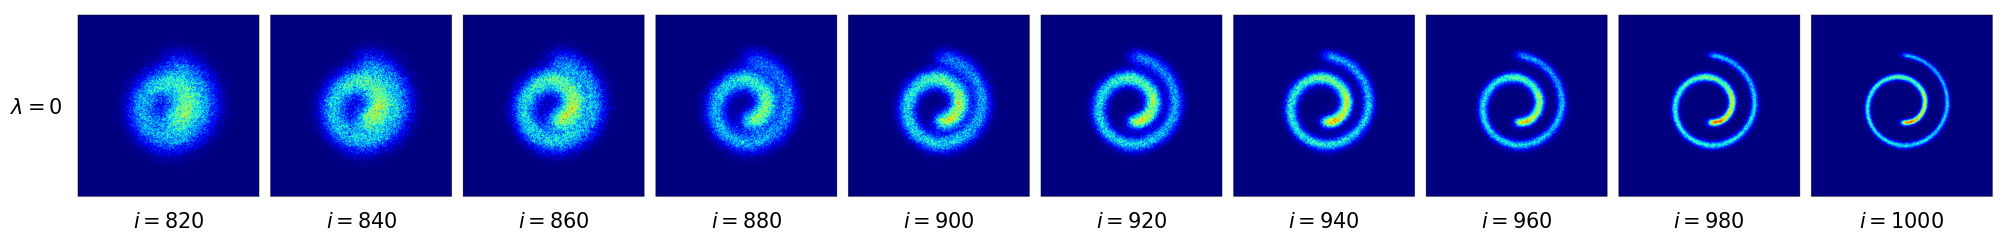

<ipython-input-17-e4d7318f1b85>:31: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


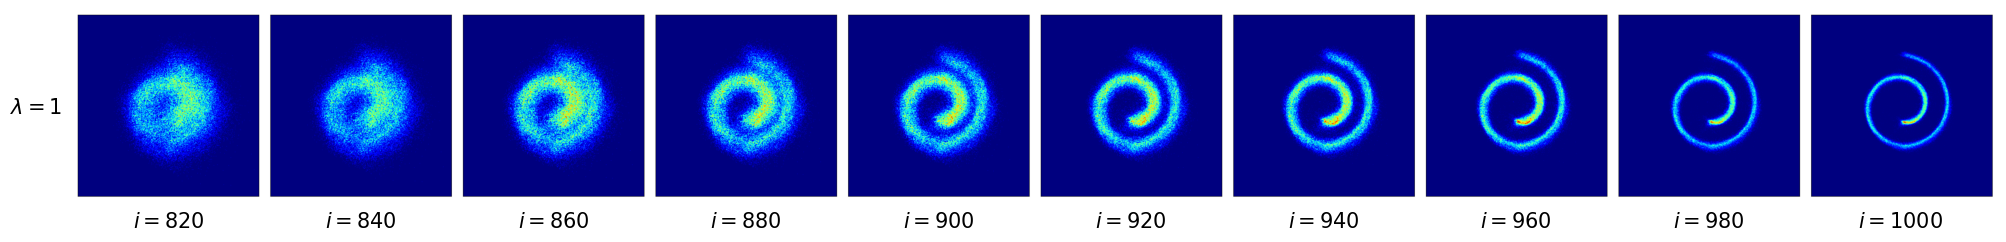

In [ ]:
"""
Simulate the generative SDE by using Euler Maruyama method
"""
# init EM param
num_steps = 1000
num_samples = 100000

# lambdas
lmbds = [0., 1.0]
# lmbds = [-10., -0.99, -0.9, -0.5, 0., 0.5, 0.9, 0.99, 1.0]

# indices to visualize
num_figs = 10
fig_step = 20 #100
inds = [i-1 for i in range(num_steps-(num_figs-1)*fig_step, num_steps+1, fig_step)]

# sample and plot
plt.close('all')
for lmbd in lmbds:
    x_0 = torch.randn(num_samples, 2, device=device) # init from prior
    xs = euler_maruyama_sampler(gen_sde, x_0, num_steps, lmbd=lmbd) # sample
    plot_selected_inds(xs, inds) # plot
    time.sleep(0.5)